In [4]:
# 📦 Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 📂 Load the predictions CSV
df = pd.read_csv("predictions_reg_final_avg_scr0p00.csv")  
df.head()


,Label,AvgPredicted,AvgTrue
0,ATCAAAATATGAGAGCACATGTTTGCTGCCATTAGA,0.730193,0.764834
1,GACACTAAGCTTCTTCCCAGGTTTTCAGATTCCGAA,0.497329,-0.795107
2,AGAGGGGAATCTTTCCACGTGCACCCAGTTCTTTTT,1.024599,1.115370
3,TAACCTAAAAGTGGCCATGAGGTCTGAGATGCTATT,0.565076,0.243808
4,AGTCATACACAAGGCCATGTGCTCATCCAGAAAGCG,0.195153,1.376702


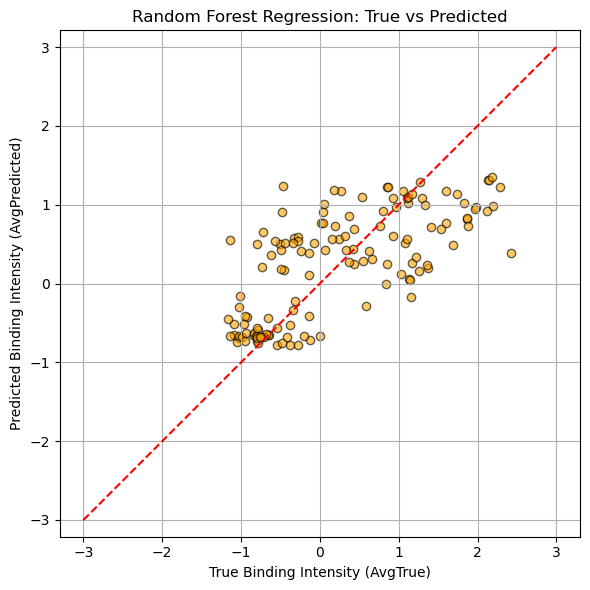

In [5]:
# 📈 Scatter plot: True vs Predicted Binding Intensities
plt.figure(figsize=(6, 6))
plt.scatter(df['AvgTrue'], df['AvgPredicted'], alpha=0.6, color='orange', edgecolors='k')
plt.plot([-3, 3], [-3, 3], 'r--')  # Ideal diagonal line
plt.xlabel("True Binding Intensity (AvgTrue)")
plt.ylabel("Predicted Binding Intensity (AvgPredicted)")
plt.title("Random Forest Regression: True vs Predicted")
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()


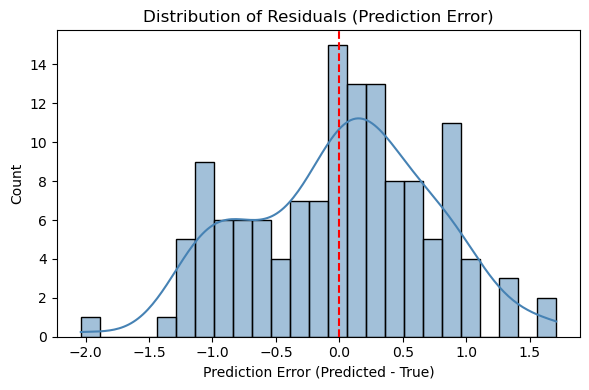

In [6]:
# 📊 Residual plot: Error distribution (Predicted - True)
df["residual"] = df["AvgPredicted"] - df["AvgTrue"]

plt.figure(figsize=(6, 4))
sns.histplot(df["residual"], kde=True, color="steelblue", bins=25)
plt.title("Distribution of Residuals (Prediction Error)")
plt.xlabel("Prediction Error (Predicted - True)")
plt.ylabel("Count")
plt.axvline(0, color='red', linestyle='--')
plt.tight_layout()
plt.show()


In [7]:
# 📈 Correlation and R² manually
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(df['AvgTrue'], df['AvgPredicted'])
mse = mean_squared_error(df['AvgTrue'], df['AvgPredicted'])

print(f"R² score: {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print("Pearson Correlation:", df[['AvgTrue', 'AvgPredicted']].corr().iloc[0, 1])


R² score: 0.4880
Mean Squared Error (MSE): 0.5064
Pearson Correlation: 0.6988563001290469


In [8]:
# Sort sequences by largest prediction error
df["abs_error"] = abs(df["AvgPredicted"] - df["AvgTrue"])
top_errors = df.sort_values(by="abs_error", ascending=False).head(10)
top_errors

#You’ll learn which sequences your model struggles with the most — these may be biologically interesting or noisy cases.


,Label,AvgPredicted,AvgTrue,residual,abs_error
25,ATTGCCCGAGCCCGCCACGTGGCAGTCTGGGCCGAA,0.390589,2.428482,-2.037893,2.037893
54,GAGATGGGCAGACGGCACGAGGAGTCGGGCAGCAGT,1.241714,-0.468448,1.710161,1.710161
13,CCAGCCTGGACCGCCCCTGTGGGCTCCACTCCCCTC,0.545967,-1.137242,1.683209,1.683209
100,CCCCCAGCGCTCCGGCACGCGCCGGGAGACCTCCGG,0.903807,-0.483023,1.386830,1.386830
126,GGCGGCGGCAGCTGCAGCGTGCAGCGCTGGGAGGCC,0.651385,-0.724828,1.376213,1.376213
17,GAAAACCAGCGAGACCGCATGGTCTCACTTATAAGT,-0.176868,1.152711,-1.329579,1.329579
1,GACACTAAGCTTCTTCCCAGGTTTTCAGATTCCGAA,0.497329,-0.795107,1.292437,1.292437
79,GCCTTTCTCAGGCTCCACGTGGTGACGAGATGGTTG,0.982659,2.189944,-1.207285,1.207285
83,CGCGGAGACCCGAAGCACGTGGTATCCATACTAGTT,0.919940,2.121860,-1.201920,1.201920
116,TTTTCTTTCCGTGGCCACGTGCAGACTGGCCCAGGT,0.491332,1.683651,-1.192319,1.192319


Text(0.5, 1.0, 'GC Content vs Prediction Error')

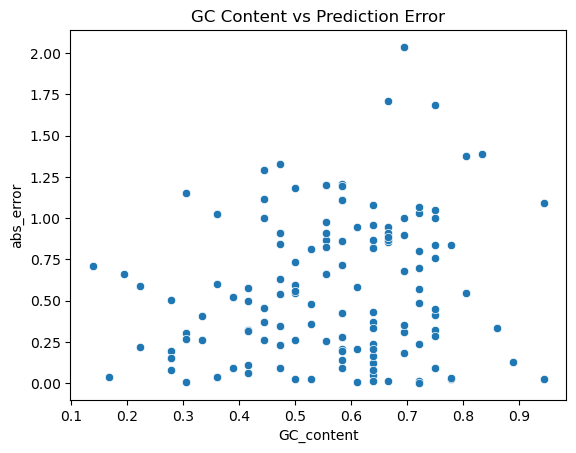

In [9]:
# Calculate GC content
df["GC_content"] = df["Label"].apply(lambda seq: (seq.count("G") + seq.count("C")) / len(seq))
sns.scatterplot(data=df, x="GC_content", y="abs_error")
plt.title("GC Content vs Prediction Error")


Text(0.5, 1.0, 'Model Calibration')

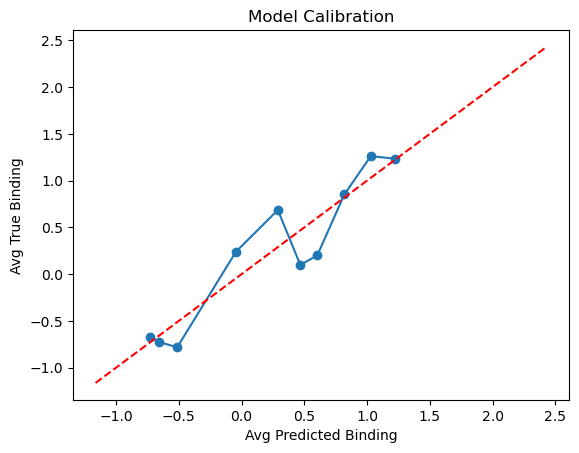

In [11]:
# Bin predictions and plot average predicted vs average true

# To see if the model is under- or over-confident at different binding levels.


df['bin'] = pd.qcut(df['AvgPredicted'], q=10, duplicates='drop')
calib = df.groupby('bin')[['AvgPredicted', 'AvgTrue']].mean()

plt.plot(calib['AvgPredicted'], calib['AvgTrue'], marker='o')
plt.plot([df['AvgTrue'].min(), df['AvgTrue'].max()], 
         [df['AvgTrue'].min(), df['AvgTrue'].max()], 'r--')
plt.xlabel("Avg Predicted Binding")
plt.ylabel("Avg True Binding")
plt.title("Model Calibration")


Text(0.5, 1.0, 'Sequence Embedding Colored by Error')

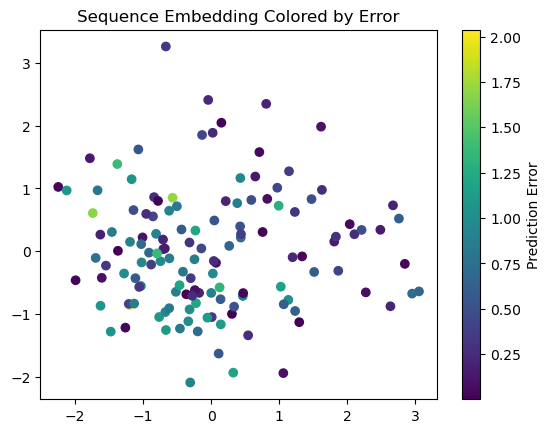

In [14]:
from sklearn.decomposition import PCA

# One-hot encode the sequences (simple encoding)
def one_hot(seq):
    return [1 if base == b else 0 for b in "ACGT" for base in seq]

one_hot_matrix = df["Label"].apply(one_hot).tolist()
X = pd.DataFrame(one_hot_matrix)

# PCA projection
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['abs_error'], cmap='viridis')
plt.colorbar(label='Prediction Error')
plt.title("Sequence Embedding Colored by Error")

#Visualize whether certain sequence clusters have high or low errors — you might discover sequence motifs that matter.